In [1]:
import configparser
import getpass
import os
import requests

In [2]:
os.environ['GITHUB_USER'] = input('Github Username: ')

Github Username: ianabc


In [4]:
os.environ['GITHUB_API_KEY'] = getpass.getpass(prompt='GitHubAPI Key: ', stream=None)

GitHubAPI Key: ········


# Github API Requests

In this notebook, we'll play a little bit with the [GitHub API](https://developer.github.com/v3/). When you are working with _any_ API, please pay attention to any [rate limiting](https://developer.github.com/v3/#rate-limiting) they have in place. Often providers will have different rate limits depending on whether or not you are authenticated.

The two cells above will prompt you to put your some github accounts details. If you don't already have a GitHub API key, you can generate one for yourself [From here](https://github.com/settings/tokens). You should treat API keys securely, if they are leaked the will allow people to (ab)use your account. The nice thing about API keys is you can usually restrict how the can be used and you can delete them when they've served their purpose. 

For this notebook, we'll put our API keys into environment variables. These will be destroyed when our session ends.  If you just stored your keys as a python variables they would be storead along with your code, when you share your notebook with someone or post it to github, people would have access to your keys. More generally, it is a good idea to separate configuration from code and environment variables is one good way of doing that.

Setting the variables every time you open this notebook can be irritating, but this is an _interactive_ tutorial, so we'll live with it. If you end up doing this a lot, there are modules (e.g. [configparser](https://docs.python.org/3/library/configparser.html)) which can help you manage them as files. Just make sure you set secure permissions on those files and never store them under version control (it's too easy to push to github!)

In [5]:
assert len(os.environ['GITHUB_USER']) > 0, "Unset GitHub Username"
assert len(os.environ['GITHUB_API_KEY']) > 0, "Unset GitHub Password"

In [6]:
payload = {'q': 'nbformat_minor+extension:ipynb'}
resp = requests.get(
    'https://api.github.com/search/code',
    params=payload,
    auth=(os.environ.get('GITHUB_USER'), os.environ.get('GITHUB_API_KEY'))
)
resp.raise_for_status()


In [7]:
resp.json()['total_count']

7740605

Actually, [Peter Parente](`https://github.com/parente`) has been tracking this quantity for years, his data is available as a CSV, so with a little bit of pandas...

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
nbHitsDF = pd.read_csv(
    'https://raw.githubusercontent.com/parente/nbestimate/master/ipynb_counts.csv',
    parse_dates=['date'],
    index_col='date'
)
nbHitsDF.tail()

,hits
date,
2020-05-29,7729962
2020-05-30,7728313
2020-05-31,7738393
2020-06-01,7761755
2020-06-02,7775264


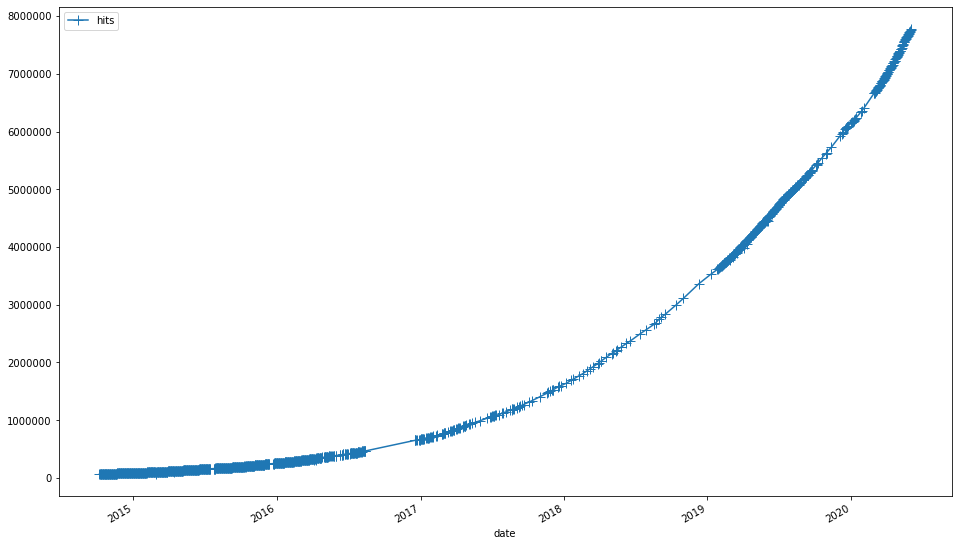

In [16]:
nbHitsDF.plot(
    markersize=10,
    marker='+',
    figsize=(16,10)
)

Looks like an exponential to me...

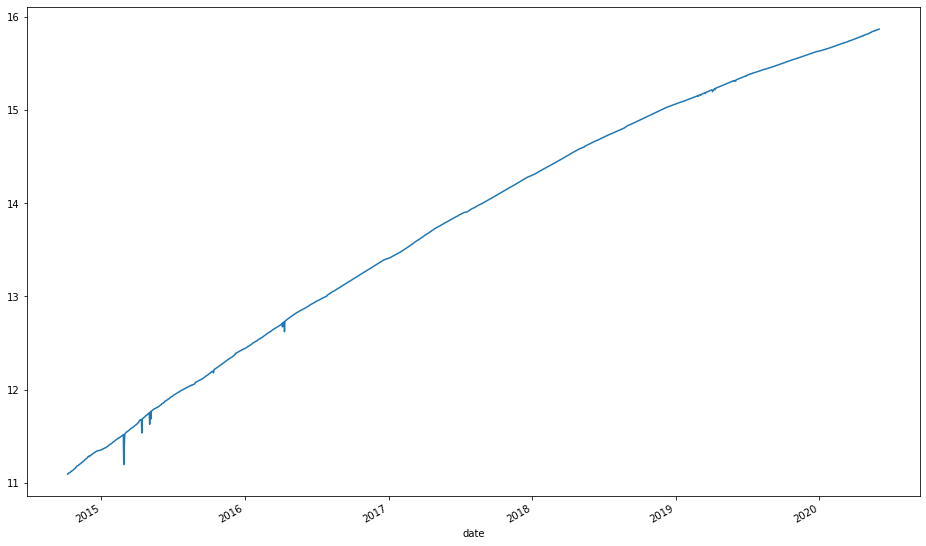

In [17]:
nbHitsDF['logHits'] = np.log(nbHitsDF['hits'])
nbHitsDF['logHits'].plot(figsize=(16,10))

OK, maybe just a little bit less than exponential, but still! There are probably better ways of doing this, but...

In [18]:
nbHitsDF['sinceStart'] = (nbHitsDF.index - nbHitsDF.index[0]).days

In [19]:
params = np.polyfit(nbHitsDF['sinceStart'], nbHitsDF['logHits'], 2)

params

array([-4.47659971e-07,  3.24708187e-03,  1.10771887e+01])

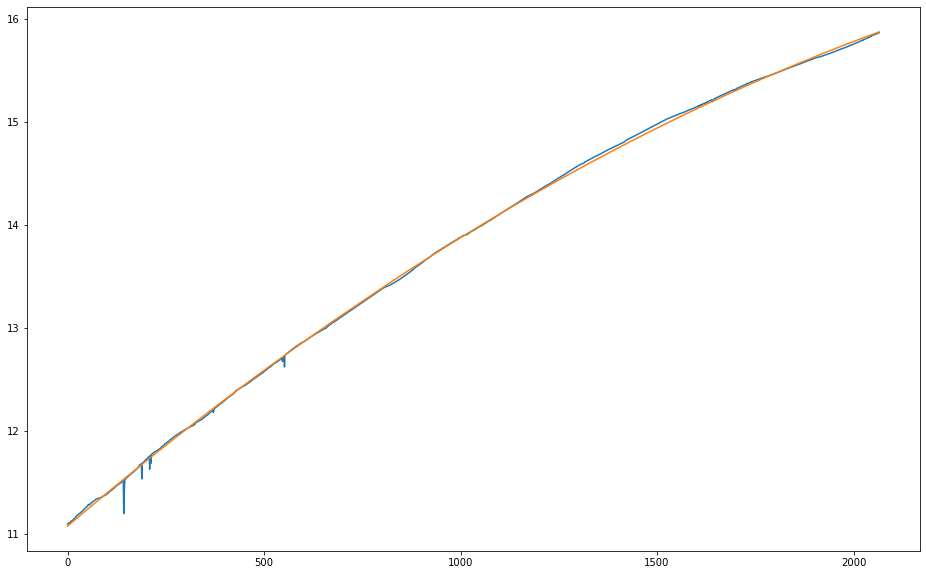

In [20]:
fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(1, 1, 1)
ax.plot(nbHitsDF['sinceStart'], nbHitsDF['logHits'])
ax.plot(
    nbHitsDF['sinceStart'], 
    params[2] + nbHitsDF['sinceStart'] * (params[1] + nbHitsDF['sinceStart'] * params[0])
)

**TODO**: Try to figure out when GitHub will have more than 8M notebooks

## User endpoint

The endpoint for user repositories is https://api.github.com/users/<username>/repos. Let's see what repositories we can find, (try your own github username if you like)

In [23]:
payload = {'sort': 'push'}
resp = requests.get(
    'https://api.github.com/users/torvalds/repos',
    params=payload,
    auth=(os.environ.get('GITHUB_USER'), os.environ.get('GITHUB_API_KEY'))
)
resp.raise_for_status()

In [24]:
torvaldsDF = pd.read_json(resp.text)
torvaldsDF

,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,mirror_url,archived,disabled,open_issues_count,license,forks,open_issues,watchers,default_branch,permissions
0,117900805,MDEwOlJlcG9zaXRvcnkxMTc5MDA4MDU=,uemacs,torvalds/uemacs,False,"{'login': 'torvalds', 'id': 1024025, 'node_id'...",https://github.com/torvalds/uemacs,Random version of microemacs with my private m...,False,https://api.github.com/repos/torvalds/uemacs,...,NaN,False,False,18,None,94,18,520,master,"{'admin': False, 'push': False, 'pull': True}"
1,113099837,MDEwOlJlcG9zaXRvcnkxMTMwOTk4Mzc=,pesconvert,torvalds/pesconvert,False,"{'login': 'torvalds', 'id': 1024025, 'node_id'...",https://github.com/torvalds/pesconvert,Brother PES file converter,False,https://api.github.com/repos/torvalds/pesconvert,...,NaN,False,False,4,None,23,4,134,master,"{'admin': False, 'push': False, 'pull': True}"
2,86106493,MDEwOlJlcG9zaXRvcnk4NjEwNjQ5Mw==,test-tlb,torvalds/test-tlb,False,"{'login': 'torvalds', 'id': 1024025, 'node_id'...",https://github.com/torvalds/test-tlb,Stupid memory latency and TLB tester,False,https://api.github.com/repos/torvalds/test-tlb,...,NaN,False,False,3,"{'key': 'gpl-2.0', 'name': 'GNU General Public...",99,3,270,master,"{'admin': False, 'push': False, 'pull': True}"
3,79171906,MDEwOlJlcG9zaXRvcnk3OTE3MTkwNg==,libdc-for-dirk,torvalds/libdc-for-dirk,False,"{'login': 'torvalds', 'id': 1024025, 'node_id'...",https://github.com/torvalds/libdc-for-dirk,"Only use for syncing with Dirk, don't use for ...",True,https://api.github.com/repos/torvalds/libdc-fo...,...,NaN,False,False,0,"{'key': 'lgpl-2.1', 'name': 'GNU Lesser Genera...",24,0,65,Subsurface-branch,"{'admin': False, 'push': False, 'pull': True}"
4,78665021,MDEwOlJlcG9zaXRvcnk3ODY2NTAyMQ==,subsurface-for-dirk,torvalds/subsurface-for-dirk,False,"{'login': 'torvalds', 'id': 1024025, 'node_id'...",https://github.com/torvalds/subsurface-for-dirk,Do not use - the real upstream is Subsurface-...,True,https://api.github.com/repos/torvalds/subsurfa...,...,NaN,False,False,0,"{'key': 'gpl-2.0', 'name': 'GNU General Public...",35,0,115,master,"{'admin': False, 'push': False, 'pull': True}"
5,2325298,MDEwOlJlcG9zaXRvcnkyMzI1Mjk4,linux,torvalds/linux,False,"{'login': 'torvalds', 'id': 1024025, 'node_id'...",https://github.com/torvalds/linux,Linux kernel source tree,False,https://api.github.com/repos/torvalds/linux,...,NaN,False,False,328,"{'key': 'other', 'name': 'Other', 'spdx_id': '...",31949,328,91812,master,"{'admin': False, 'push': False, 'pull': True}"


**TODO**: See if you can extract linus' public key!

In [25]:
resp = requests.get(
    'https://api.github.com/users/torvalds/keys',
    auth=(os.environ.get('GITHUB_USER'), os.environ.get('GITHUB_API_KEY'))
)
resp.raise_for_status()
pd.read_json(resp.text)

,id,key
0,1306333,ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABAQCoQ9S7V+...


## Other Endpoints

There are [lots of other interesting endpoints](https://developer.github.com/v3) to play with, here are some of the more interesting ones:

  * [Collaborators](https://developer.github.com/v3/repos/collaborators/)
  * [Repositories](https://developer.github.com/v3/repos) - List repos, create new ones etc.
    * [Commits](https://developer.github.com/v3/repos/commits/) - examine past commits
    * [Statistics](https://developer.github.com/v3/repos/statistics/) - repository stats, who commits most often etc.
  * [Search](https://developer.github.com/v3/search/) - Find all the data
    * [Commits](https://developer.github.com/v3/search/#search-commits)
    * [Users](https://developer.github.com/v3/search/#search-users)
    * [Repositories](https://developer.github.com/v3/search/#search-repositories)
    * [Issues](https://developer.github.com/v3/search/#search-issues-and-pull-requests)
  * [Pull Requests](https://developer.github.com/v3/pulls/) - Creation and merge PRs automatically!
  
  
I'd _strongly_ recommend sticking to the GET methods until you are comfortable, but once you are ready, the (requests)[https://2.python-requests.org/en/master/] module has all of the options you need to make POST/PUT/DELETE requests to make changes.
